# Segmentation loss walk-thru

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [112]:
import argparse
import itertools
import os, sys
import pickle, shutil
from datetime import datetime
from pathlib import Path

import PIL, cv2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

In [3]:
import IIC.archs as archs
from IIC.utils.cluster.general import config_to_str, get_opt, update_lr, nice
from IIC.utils.cluster.transforms import sobel_process
from IIC.utils.segmentation.segmentation_eval import segmentation_eval
from IIC.utils.segmentation.IID_losses import (IID_segmentation_loss, 
                                               IID_segmentation_loss_uncollapsed)
from IIC.utils.segmentation.data import segmentation_create_dataloaders
from IIC.utils.segmentation.general import set_segmentation_input_channels
from IIC.datasets.segmentation.potsdam import Potsdam

In [4]:
def _cp(src, dst):
    assert src.is_file()
    shutil.copy(src, dst)
    
Path.cp = _cp
Path.ls = lambda o: list(o.iterdir())

## Config

The following run taken from `examples/commands.txt` for a semi-supervised over-clustering segmentation of the Potsdam-3 dataset will be looked at here.

```
Potsdam-3 (482)
export CUDA_VISIBLE_DEVICES=2,3 && nohup python -m code.scripts.segmentation.segmentation --mode IID+ --dataset Potsdam --dataset_root /scratch/local/ssd/xuji/POTSDAM --model_ind 482 --arch SegmentationNet10a --num_epochs 4800 --lr 0.00001 --lamb 1.0 --num_sub_heads 1 --batch_sz 75 --num_dataloaders 1 --use_coarse_labels --output_k 9 --gt_k 3 --input_sz 200 --half_T_side_sparse_min 0 --half_T_side_sparse_max 0 --half_T_side_dense 10 --include_rgb --no_sobel --jitter_brightness 0.1 --jitter_contrast 0.1 --jitter_saturation 0.1 --jitter_hue 0.1 --use_uncollapsed_loss --batchnorm_track > sh13_gpu23_m482_r1.out &
```

In [5]:
class Config:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model_ind = 482            # type=int, required=True
    arch = 'SegmentationNet10a'# type=str, required=True
    opt = 'Adam'   
    mode = 'IID+'  
    dataset = 'Potsdam'        # type=str, required=True
    dataset_root = '/scratch/local/ssd/xuji/POTSDAM'  # type=str, required=True
    use_coarse_labels = False  # default=False, action="store_true")  # COCO, Potsdam
    fine_to_coarse_dict = ("/users/xuji/iid/iid_private/code/datasets"
                           "/segmentation/util/out/fine_to_coarse_dict.pickle")
    include_things_labels = False 
    incl_animal_things = False 
    coco_164k_curated_version = -1
    gt_k = 3                   # type=int, required=True
    output_k = 9               # type=int, required=True
    lamb = 1.0  
    lr = 0.01
    lr_schedule = []
    lr_mult = .1
    use_uncollapsed_loss = False
    mask_input = False
    num_epochs = 1000
    batch_sz = 75 # type=int, required=True  # num pairs
    num_dataloaders = 3
    num_sub_heads = 5
    out_root = "iid_private"
    restart = False
    save_freq = 5 
    test_code = False 
    batchnorm_track = False 
    # data transforms
    no_sobel = False 
    include_rgb = False
    pre_scale_all = False
    pre_scale_factor = .5
    use_random_scale = False
    scale_min = 6. 
    scale_max = 1.4 
    input_sz = 161 
    # transforms we learn invariance to
    jitter_brightness = .4
    jitter_contrast = .4 
    jitter_saturation = 0.4
    jitter_hue = 0.125
    flip_p = 0.5

    use_random_affine = False
    aff_min_rot = -30. # degrees
    aff_max_rot = 30.  # degrees
    aff_min_shear = -10.  # degrees
    aff_max_shear = 10.  # degrees
    aff_min_scale = 0.8
    aff_max_scale = 1.2

# local spatial invariance. Dense means done convolutionally. Sparse means done
#  once in data augmentation phase. These are not mutually exclusive
    half_T_side_dense = 0
    half_T_side_sparse_min = 0
    half_T_side_sparse_max = 0

In [6]:
config = Config()

Set the parameters values according to the command given above.

In [7]:
config.mode = 'IID+'
config.dataset = 'Potsdam'
config.dataset_root = '/Users/jack/git_repos/IIC/datasets/POTSDAM/'
config.model_ind = 482
config.arch = 'SegmentationNet10a'
config.num_epochs = 4800
config.lr = 0.00001
config.lamb = 1.0
config.num_sub_heads = 1
config.batch_sz = 32
config.num_dataloaders = 1
config.use_coarse_labels = True
config.output_k = 9 
config.gt_k = 3 
config.input_sz = 200
config.half_T_side_sparse_min = 0 
config.half_T_side_sparse_max = 0 
config.half_T_side_dense = 10
config.include_rgb = True
config.no_sobel = True
config.jitter_brightness = 0.1 
config.jitter_contrast = 0.1 
config.jitter_saturation = 0.1 
config.jitter_hue = 0.1
config.use_uncollapsed_loss = True
config.batchnorm_track = True

### Further setup

In [8]:
config.out_dir = os.path.join(config.out_root, str(config.model_ind))
config.dataloader_batch_sz = int(config.batch_sz / config.num_dataloaders)
assert (config.mode == "IID+")
assert (config.output_k >= config.gt_k)
assert (not (config.no_sobel and (not config.include_rgb)))
config.eval_mode = "orig"
config.use_doersch_datasets = False
set_segmentation_input_channels(config)

if not os.path.exists(config.out_dir):
    os.makedirs(config.out_dir)
    
if config.restart:
    config_name = "config.pickle"
    dict_name = "latest.pytorch"

    given_config = config
    reloaded_config_path = os.path.join(given_config.out_dir, config_name)
    print("Loading restarting config from: %s" % reloaded_config_path)
    with open(reloaded_config_path, "rb") as config_f:
        config = pickle.load(config_f)
    assert (config.model_ind == given_config.model_ind)
    config.restart = True

    # copy over new num_epochs and lr schedule
    config.num_epochs = given_config.num_epochs
    config.lr_schedule = given_config.lr_schedule
else:
    print("Given config: %s" % config_to_str(config))

Given config: Config: -----
mode: IID+
dataset: Potsdam
dataset_root: /Users/jack/git_repos/IIC/datasets/POTSDAM/
model_ind: 482
arch: SegmentationNet10a
num_epochs: 4800
lr: 1e-05
lamb: 1.0
num_sub_heads: 1
batch_sz: 32
num_dataloaders: 1
use_coarse_labels: True
output_k: 9
gt_k: 3
input_sz: 200
half_T_side_sparse_min: 0
half_T_side_sparse_max: 0
half_T_side_dense: 10
include_rgb: True
no_sobel: True
jitter_brightness: 0.1
jitter_contrast: 0.1
jitter_saturation: 0.1
jitter_hue: 0.1
use_uncollapsed_loss: True
batchnorm_track: True
out_dir: iid_private/482
dataloader_batch_sz: 32
eval_mode: orig
use_doersch_datasets: False
in_channels: 4
using_IR: True
----------


## Data

In [9]:
dataloaders, mapping_assignment_dataloader, mapping_test_dataloader = \
segmentation_create_dataloaders(config)

Creating paired dataloader 0 out of 1 time 2020-09-30 11:26:58.733130
Length of paired datasets vector 1
Number of batches per epoch: 241


### Quick look at a batch

In [10]:
img1, img2, tfm, mask = next(iter(dataloaders[0]))

In [11]:
img1.shape, img2.shape, tfm.shape, mask.shape

(torch.Size([32, 4, 200, 200]),
 torch.Size([32, 4, 200, 200]),
 torch.Size([32, 2, 3]),
 torch.Size([32, 200, 200]))

In [12]:
img1 = img1.cpu()
img2 = img2.cpu()
tfm = tfm.cpu()
mask = mask.cpu()

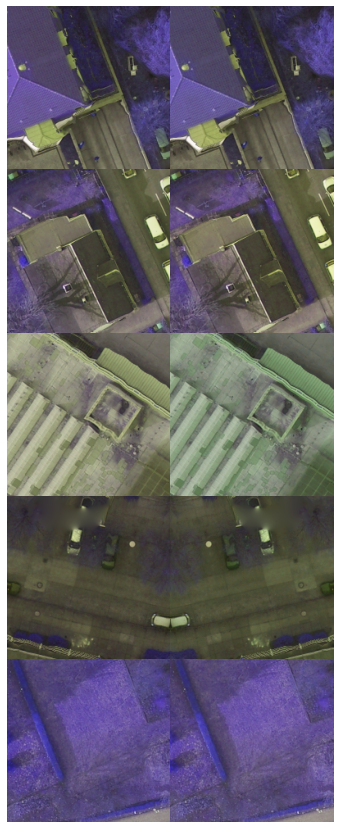

In [13]:
n = 5
ncols = 2
nrows = 5
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(ncols*3, nrows*3))
for row, im1, im2 in zip(axs, img1[11:11+n], img2[11:11+n]):
    for ax in row: ax.axis('off')
    im1 = im1[1:4].permute(1, 2, 0).numpy()
    im2 = im2[1:4].permute(1, 2, 0).numpy()
    row[0].imshow(im1)
    row[1].imshow(im2)
    
fig.subplots_adjust(hspace=0, wspace=-.05)

In [14]:
del img1, img2, tfm, mask

## Model

In [56]:
config.arch

'SegmentationNet10a'

In [57]:
from IIC.archs.segmentation.net10a import SegmentationNet10a

In [58]:
model = SegmentationNet10a(config)

In [59]:
next(model.trunk.parameters())[0].device

device(type='cpu')

In [60]:
if config.restart:
    d_cpt = torch.load(os.path.join(config.out_dir, dict_name),
                           map_location=lambda storage, loc: storage)
    model.load_state_dict(d_cpt["net"])    

In [61]:
model.to(config.device);

In [62]:
model = torch.nn.DataParallel(model)
model.train();

In [63]:
next(model.module.trunk.parameters()).device

device(type='cpu')

In [64]:
! nvidia-smi

/bin/bash: nvidia-smi: command not found


## Optimiser

In [65]:
optimiser = get_opt(config.opt)(model.module.parameters(), lr=config.lr)

In [66]:
if config.restart:
    optimiser.load_state_dict(d_cpt['opt'])

## Initialise or load training stats

In [67]:
if config.restart:
    next_epoch = config.last_epoch + 1
    print("starting from epoch %d" % next_epoch)
    config.epoch_acc = config.epoch_acc[:next_epoch]  # in case we overshot
    config.epoch_avg_subhead_acc = config.epoch_avg_subhead_acc[:next_epoch]
    config.epoch_stats = config.epoch_stats[:next_epoch]
    config.epoch_loss = config.epoch_loss[:(next_epoch - 1)]
    config.epoch_loss_no_lamb = config.epoch_loss_no_lamb[:(next_epoch - 1)]
else:
    config.epoch_acc = []
    config.epoch_avg_subhead_acc = []
    config.epoch_stats = []
    config.epoch_loss = []
    config.epoch_loss_no_lamb = []

# # Comment out to save time, since the focus is on the loss func.
#     _ = segmentation_eval(
#         config, model, 
#         mapping_assignment_dataloader=mapping_assignment_dataloader,
#         mapping_test_dataloader=mapping_test_dataloader,
#         sobel=config.no_sobel is False,
#         using_IR=config.using_IR)
#     print(f"Pre: time {datetime.now():s}: \n"
#           f"{nice(config.epoch_stats[-1]):s}")
    sys.stdout.flush()
    next_epoch = 1

## Loss

In [68]:
if not config.use_uncollapsed_loss:
    print('using condensed loss (default)')
    loss_fn = IID_segmentation_loss
else:
    print('use uncollaped loss')
    loss_fn = IID_segmentation_loss_uncollapsed

use uncollaped loss


## Training

In [69]:
for e_i in range(next_epoch, config.num_epochs):
    if e_i == next_epoch: break

In [70]:
print(f"Starting e_i: {e_i} {datetime.now()}")

Starting e_i: 1 2020-10-02 09:35:31.826434


In [71]:
iterators = (d for d in dataloaders)

In [72]:
b_i = 0

In [73]:
if e_i in config.lr_schedule:
    optimiser = update_lr(optimiser, lr_mult=config.lr_mult)

In [74]:
avg_loss, avg_loss_no_lamb, avg_loss_count = 0, 0, 0

In [75]:
tup = next(itertools.zip_longest(*iterators))

`tup[0]` is a mini-batch from dataloader `0`. In this case, it's a 4-tuple.

In [92]:
len(tup)

1

In [76]:
tup[0][0].shape, tup[0][1].shape, tup[0][2].shape, tup[0][3].shape

(torch.Size([32, 4, 200, 200]),
 torch.Size([32, 4, 200, 200]),
 torch.Size([32, 2, 3]),
 torch.Size([32, 200, 200]))

In [77]:
model.module.zero_grad()

In [78]:
if not config.no_sobel:
    # one less because this is before sobel
    pre_channels = config.in_channels - 1
else:
    pre_channels = config.in_channels

In [80]:
all_img1 = (torch.zeros(
    config.batch_sz, pre_channels, config.input_sz, config.input_sz)
           .to(torch.float32).to(config.device))
all_img2 = (torch.zeros(
    config.batch_sz, pre_channels, config.input_sz, config.input_sz)
            .to(torch.float32).to(config.device))
all_affine2_to_1 = (torch.zeros(config.batch_sz, 2, 3)
                    .to(torch.float32).to(config.device))
all_mask_img1 = (torch.zeros(
    config.batch_sz, config.input_sz, config.input_sz)
                 .to(torch.float32).to(config.device))

In [81]:
curr_batch_sz = len(tup[0][0])

In [82]:
for d_i in range(config.num_dataloaders):
    if d_i == 0: break
d_i

0

Get dataloader `d_i`'s mini-batch.  In this case, there is actually only one dataloader.

In [83]:
img1, img2, affine2_to_1, mask_img1 = tup[d_i]
assert len(img1) == curr_batch_sz

In [84]:
actual_batch_start = d_i * curr_batch_sz
actual_batch_end = actual_batch_start + curr_batch_sz

There may be multiple dataloaders.  The mini-batch from each dataloader are concatenated to from a 'total', current mini-batch.  

In [85]:
all_img1[actual_batch_start:actual_batch_end,...] = img1
all_img2[actual_batch_start:actual_batch_end,...] = img2
all_affine2_to_1[actual_batch_start:actual_batch_end,...] = affine2_to_1
all_mask_img1[actual_batch_start:actual_batch_end,...] = mask_img1

In [86]:
if (not (curr_batch_sz==config.dataloader_batch_sz) 
    and (e_i==next_epoch)):
    print(f'last batch sz {curr_batch_sz}')

The 'total' mini-batch are stored in `all_img1`, `all_img2`, `all_affine2_to_1`, and `all_mask_img1`.

In [87]:
curr_total_batch_sz = curr_batch_sz * config.num_dataloaders
all_img1 = all_img1[:curr_total_batch_sz]
all_img2 = all_img2[:curr_total_batch_sz]
all_affine2_to_1 = all_affine2_to_1[:curr_total_batch_sz]
all_mask_img1 = all_mask_img1[:curr_total_batch_sz]

The following cell is not executed, because *no sobel* is required.

In [88]:
if not config.no_sobel:
    print(':D')
    all_img1 = sobel_process(
        all_img1, config.include_rgb, config.using_IR)
    all_img2 = sobel_process(
        all_img2, config.include_rgb, config.using_IR)

Pass the mini-batch to the model.  

Here, 2 sets of 32 images go through the model, return 2 sets of outputs.

In [94]:
all_img1.shape, all_img2.shape

(torch.Size([32, 4, 200, 200]), torch.Size([32, 4, 200, 200]))

In [89]:
%%time
x1_outs = model(all_img1)
x2_outs = model(all_img2)

/Users/jack/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/nn/functional.py:3121: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


CPU times: user 1min 43s, sys: 10.7 s, total: 1min 54s
Wall time: 1min 31s


The model output is a list of length equal to the number of sub-heads.  There's only 1 sub-head here.  

In [96]:
len(x1_outs), len(x2_outs)

(1, 1)

The output of each subhead is a batch of 32 masks with 9 prediction classes.  In this case, there are 2 batches of 32 masks.

In [99]:
x1_outs[0].shape, x2_outs[0].shape

(torch.Size([32, 9, 200, 200]), torch.Size([32, 9, 200, 200]))

In [91]:
avg_loss_batch, avg_loss_no_lamb_batch = None, None # avg over the heads

## `IID_segmentation_loss_uncollapsed()`

`IIC.utils.segmentation.IID_losses.IID_segmentation_loss_uncollapsed(x1_outs, x2_outs, all_affine2_to_1=None, all_mask_img1=None, lamb=1.0, half_T_side_dense=None, half_T_side_sparse_min=None, half_T_side_sparse_max=None)`

There's only 1 sub-head.  Go through the loss calculation for this sub-head's output.

In [101]:
for i in range(config.num_sub_heads):
    if i == 0: break

In [102]:
i

0

Define the input values:

In [103]:
x1_outs = x1_outs[i]
x2_outs = x2_outs[i]
all_affine2_to_1 = all_affine2_to_1
all_mask_img1 = all_mask_img1
lamb = config.lamb
half_T_side_dense = config.half_T_side_dense
half_T_side_sparse_min = config.half_T_side_sparse_min
half_T_side_sparse_max = config.half_T_side_sparse_max

In [105]:
assert x1_outs.requires_grad
assert x2_outs.requires_grad
assert not all_affine2_to_1.requires_grad
assert not all_mask_img1.requires_grad

In [106]:
assert x1_outs.shape == x2_outs.shape

In [109]:
all_affine2_to_1[0]

tensor([[-1., -0., -0.],
        [ 0.,  1.,  0.]])

`IIC.utils.segmentation.perform_affine_tf(data, tf_matrices)`

```
data = x2_outs
tf_matrices = all_affine2_to_1
```

In [110]:
n_i, k, h, w = x2_outs.shape
n_i2, r, c = all_affine2_to_1.shape
assert n_i == n_i2
assert r == 2 and c == 3

In [137]:
all_affine2_to_1.shape, x2_outs.shape

(torch.Size([32, 2, 3]), torch.Size([32, 9, 200, 200]))

In [131]:
grid = F.affine_grid(all_affine2_to_1, x2_outs.shape, align_corners=True)

In [136]:
grid.shape

torch.Size([32, 200, 200, 2])

In [132]:
data_tf = F.grid_sample(x2_outs, grid, padding_mode='zeros', align_corners=True)

In [133]:
data_tf.shape

torch.Size([32, 9, 200, 200])

The frame of output `x2_output` has been transformed to frame 1, via the affine transformation `all_affine2_to_1`.  `F.affine_grid`, followed `F.grid_sample`, are used to carry out this transformation.

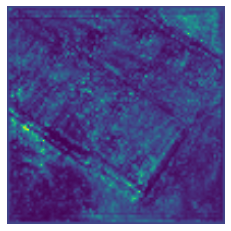

In [134]:
plt.imshow(x2_outs[0,0].detach().numpy()); plt.axis('off');

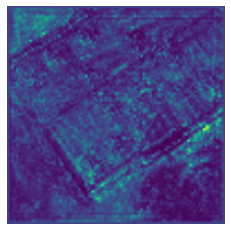

In [135]:
plt.imshow(data_tf[0,0].detach().numpy()); plt.axis('off');

End of `IIC.utils.segmentation.perform_affine_tf`

In [142]:
x2_outs_inv = data_tf

Not doing the following here:

``` python
if (half_T_side_sparse_min != 0) or (half_T_side_sparse_max != 0):
    x2_outs_inv = random_translation_multiple(
        x2_outs_inv, half_side_min=half_T_side_sparse_min,
        half_side_max=half_T_side_sparse_max)
```

Mask out irrelevant patches.  Here, actually no pixels are masked out.

In [143]:
bn, k, h, w = x1_outs.shape
all_mask_img1 = all_mask_img1.view(bn, 1, h, w)
x1_outs = all_mask_img1 * x1_outs
x2_outs_inv = all_mask_img1 * x2_outs_inv

In [146]:
x1_outs = x1_outs.permute(1,0,2,3).contiguous()
x2_outs_inv = x2_outs_inv.permute(1,0,2,3).contiguous()

In [154]:
%%time
p_i_j = F.conv2d(
    x1_outs, x2_outs_inv, padding=(half_T_side_dense, half_T_side_dense))

CPU times: user 7.69 s, sys: 65.6 ms, total: 7.75 s
Wall time: 8 s


In [167]:
x1_outs[0,0,:3,:3], x2_outs_inv[0,0,:3,:3]

(tensor([[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1079, 0.1013],
         [0.1111, 0.1013, 0.0808]], grad_fn=<SliceBackward>),
 tensor([[0.1111, 0.1111, 0.1111],
         [0.1111, 0.1115, 0.1124],
         [0.1111, 0.1124, 0.1152]], grad_fn=<SliceBackward>))

In [65]:
    loss, loss_no_lamb = loss_fn(
        x1_outs[i], x2_outs[i], 
        all_affine2_to_1=all_affine2_to_1, 
        all_mask_img1=all_mask_img1,
        lamb=config.lamb, 
        half_T_side_dense=config.half_T_side_dense,
        half_T_side_sparse_min=config.half_T_side_sparse_min,
        half_T_side_sparse_max=config.half_T_side_sparse_max)
    if avg_loss_batch is None:
        avg_loss_batch = loss
        avg_loss_no_lamb_batch = loss_no_lamb
    else:
        avg_loss_batch += loss
        avg_loss_no_lamb_batch += loss_no_lamb

avg_loss_batch /= config.num_sub_heads
avg_loss_no_lamb_batch /= config.num_sub_heads

/home/ubuntu/anaconda3/envs/engie/lib/python3.6/site-packages/torch/nn/functional.py:2764: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/ubuntu/anaconda3/envs/engie/lib/python3.6/site-packages/torch/nn/functional.py:2705: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


In [76]:
if (b_i%100)==0 or e_i==next_epoch: 
    print(f"Model ind {config.model_ind:d} "
          f"epoch {e_i:d} batch: {b_i:d} " 
          f"avg loss {avg_loss_batch.item():f} " 
          f"avg loss no lamb {avg_loss_no_lamb_batch.item():f} "
          f"time {datetime.now()}")

Model ind 482 epoch 1 batch: 0 avg loss -0.001550 avg loss no lamb -0.001550 time 2020-08-22 08:14:53.074894


In [91]:
if not np.isfinite(float(avg_loss_batch.data)):
    print(f"Loss is not finite... {str(avg_loss_batch):s}:")
    exit(1)

In [95]:
avg_loss += avg_loss_batch.item()
avg_loss_no_lamb += avg_loss_no_lamb_batch.item()
avg_loss_count += 1

In [97]:
avg_loss_batch.backward()

In [98]:
optimiser.step()

In [102]:
b_i += 1

In [100]:
# if b_i==2 and config.test_code:
#     break

SyntaxError: 'break' outside loop (<ipython-input-100-b2f777e233c1>, line 5)

# Reference

- [Invariant Information Clustering for Unsupervised Image Classification and Segmentation](https://arxiv.org/pdf/1807.06653.pdf)